# Naive-Bayes Classifier

In [ ]:
#Baseline SVM with PCA classifier
import sklearn
import numpy as np
import sklearn.datasets as skd
import ast
from sklearn.feature_extraction import DictVectorizer
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.sparse import vstack
import matplotlib.pyplot as plt
import itertools


In [2]:
import pickle

file = open("mr_train.obj",'rb')
mr_train = pickle.load(file)
file.close()

file = open("mr_test.obj",'rb')
mr_test = pickle.load(file)
file.close()

file = open("mr_cv.obj",'rb')
mr_cv = pickle.load(file)
file.close()

'''
file = open("b_train.obj",'rb')
b = pickle.load(file)
file.close()

file = open("c_cv.obj",'rb')
c = pickle.load(file)
file.close()

file = open("d_test.obj",'rb')
d = pickle.load(file)
file.close()
'''

file = open("x_train.obj",'rb')
x_train = pickle.load(file)
file.close()


file = open("x_test.obj",'rb')
x_test = pickle.load(file)
file.close()

file = open("x_cv.obj",'rb')
x_cv = pickle.load(file)
file.close()

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(20,10))
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=10)
    plt.yticks(tick_marks, classes,fontsize=10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:



print("Training data has %d malware samples and %d features" % (x_train.shape[0], x_train.shape[1]))
print("Crossval data has %d malware samples and %d features" % (x_cv.shape[0], x_cv.shape[1]))
print("Test data has %d malware samples and %d features" % (x_test.shape[0], x_test.shape[1]))

print("Performing IG Feature selection...")

indices=np.argsort(np.asarray(x_train.sum(axis=0)).ravel(),axis=0)[::-1]
x_train_ig = x_train[:,indices]
x_cv_ig = x_cv[:,indices]
x_test_ig = x_test[:,indices]

print("Training NB Classifier with top 5000 IG features ...")
NB = sklearn.naive_bayes.MultinomialNB()
NB.fit(x_train_ig,mr_train.target)

print("Obtaining predictions on test data...")
y_pred_cv=NB.predict(x_cv_ig)
y_pred_test=NB.predict(x_test_ig)

prec_cv, rec_cv, fsc_cv, sup_cv = precision_recall_fscore_support(mr_cv.target, y_pred_cv, average='weighted')
prec_test, rec_test, fsc_test, sup_test = precision_recall_fscore_support(mr_test.target, y_pred_test, average='weighted')

print("Precision on crossval data is %.4f" % prec_cv)
print("Recall on crossval data is %.4f" % rec_cv)
print("Precision on test data is %.4f" % prec_test)
print("Recall on test data is %.4f" % rec_test)

Training data has 5757 malware samples and 425200 features
Crossval data has 1237 malware samples and 425200 features
Test data has 2067 malware samples and 425200 features
Performing IG Feature selection...
Training NB Classifier with top 5000 IG features ...
Obtaining predictions on test data...
Precision on crossval data is 0.9023
Recall on crossval data is 0.8925
Precision on test data is 0.1149
Recall on test data is 0.1190


/beegfs/vvb231/py3.6/py3.6.3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
#Distance measure to class centroids
#Confusion Matrices




print("Finding class centroids and computing distance of samples to centroids")
clf = NearestCentroid()
clf.fit(x_train_ig,mr_train.target)

dist_train = pairwise_distances(x_train_ig, clf.centroids_)
dist_test = pairwise_distances(x_test_ig, clf.centroids_)

print("Calculating drift_l2 thresholds...")
m = np.resize(np.array([]),8)
var = np.resize(np.array([]),8)
thresh = np.resize(np.array([]),8)
for i in range(8):
    m[i] = np.mean(dist_train[np.where(np.argmin(dist_train,axis=1)==i)][:,i])
    var[i] = np.sqrt(np.std(dist_train[np.where(np.argmin(dist_train,axis=1)==i)][:,i]))
    thresh[i] = m[i]+var[i] 
    

test_drift_l2 = np.resize(np.array([]),8)
test_total = np.resize(np.array([]),8)
test_d_per = np.resize(np.array([]),8)

"Calculating drift_l2 on test data with new classes..."
for r in range(8):
    test_drift_l2[r]=sum(dist_test[np.where(np.argmin(dist_test,axis=1)==r)][:,r] > thresh[r])
    test_total[r]= sum(np.argmin(dist_test,axis=1)==r)
    if test_total[r]!=0:
        test_d_per[r]=test_drift_l2[r]/test_total[r]
    else:
        test_d_per[r]='nan'
        
print("In test set there are %d drift_l2ed malware of a total of %d samples, total drift_l2 percentage is %.4f" % (sum(test_drift_l2), sum(test_total), sum(test_drift_l2)/sum(test_total)))

print("Selecting drift_l2ed malware samples from test set...")
ind_array_test = np.array([])
indices_test = np.array([])

for i in range(8):
    ind_array_test = np.where(np.argmin(dist_test,axis=1)==i)
    indices_test = np.append(indices_test,ind_array_test[0][dist_test[np.where(np.argmin(dist_test,axis=1)==i)][:,i] > thresh[i]])

print("Appending drift_l2ed malware samples from test set to training set, and re-labelling...")
x_train_drift_l2 = vstack([x_train_ig,x_test_ig[indices_test.astype(int)]])
mr_train_drift_l2_target = np.append(mr_train.target,mr_test.target[indices_test.astype(int)],axis=0)

print("Training drift_l2-Aware SVM classifier with new training set...")
NB_drift_l2 = sklearn.naive_bayes.MultinomialNB()
NB_drift_l2.fit(x_train_drift_l2,mr_train_drift_l2_target)

print("Computing predictions on test data with newly trained model...")
y_drift_l2 = NB_drift_l2.predict(x_test_ig)

prec_drift_l2, rec_drift_l2, fsc_drift_l2, sup_drift_l2 = precision_recall_fscore_support(mr_test.target,y_drift_l2, average='weighted')

print("Precision on test data with new classes with original model was %.4f" %prec_test)
print("Recall on test data with new classes with original model was %.4f" %rec_test)
print("Precision on test data with new classes with concept drift_l2-aware model %.4f" %prec_drift_l2)
print("Recall on test data with new classes with concept drift_l2-aware model %.4f" %rec_drift_l2)



Finding class centroids and computing distance of samples to centroids
Calculating drift_l2 thresholds...
In test set there are 699 drift_l2ed malware of a total of 1314 samples, total drift_l2 percentage is 0.5320
Selecting drift_l2ed malware samples from test set...
Appending drift_l2ed malware samples from test set to training set, and re-labelling...
Training drift_l2-Aware SVM classifier with new training set...
Computing predictions on test data with newly trained model...
Precision on test data with new classes with original model was 0.1149
Recall on test data with new classes with original model was 0.1190
Precision on test data with new classes with concept drift_l2-aware model 0.5921
Recall on test data with new classes with concept drift_l2-aware model 0.4465


In [15]:
# Computing intersections of flagged samples and actual new class samples for l2 centroid drift
intersection = np.intersect1d(np.sort(indices_test),np.flatnonzero(mr_test.target > 7))
print(intersection.shape)
print("Precision with mean + 1std threshold is %.4f, recall is %.4f, flagged samples are %d, percentage of samples flagged is %.4f and percentage of flagged samples that actually belong to new families is %.4f" % (prec_drift_l2,rec_drift_l2,len(indices_test),np.double(len(indices_test))/np.double(len(mr_test.data)),np.double(intersection.shape[0])/np.double(np.flatnonzero(mr_test.target > 7).size)))


(489,)
Precision with mean + 1std threshold is 0.5921, recall is 0.4465, flagged samples are 699, percentage of samples flagged is 0.3382 and percentage of flagged samples that actually belong to new families is 0.3159


Computing confusion matrices...
Plotting confusion matrix for crossvalidation data
Confusion matrix, without normalization
[[ 28   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  1 138   0   1   1   0   0   1   0   1   0   0   0   0   0   0   0   0
    1   0   0   0   5   1   0]
 [  0   0  27   0   0   0   1   0   0   0   0   0   0   0   0   0   1   1
    0   0   0   0   0   3   0]
 [  0   0   0  42   2   2   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   5   1]
 [  0   0   0   0  18   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0  40   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   1 143   0   0   0   0   2   0   0   0   0   0   0
    0   0   0   1   0   3   0]
 [  0   0   0   0   0   0   0  17   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   1   1   1   0   9

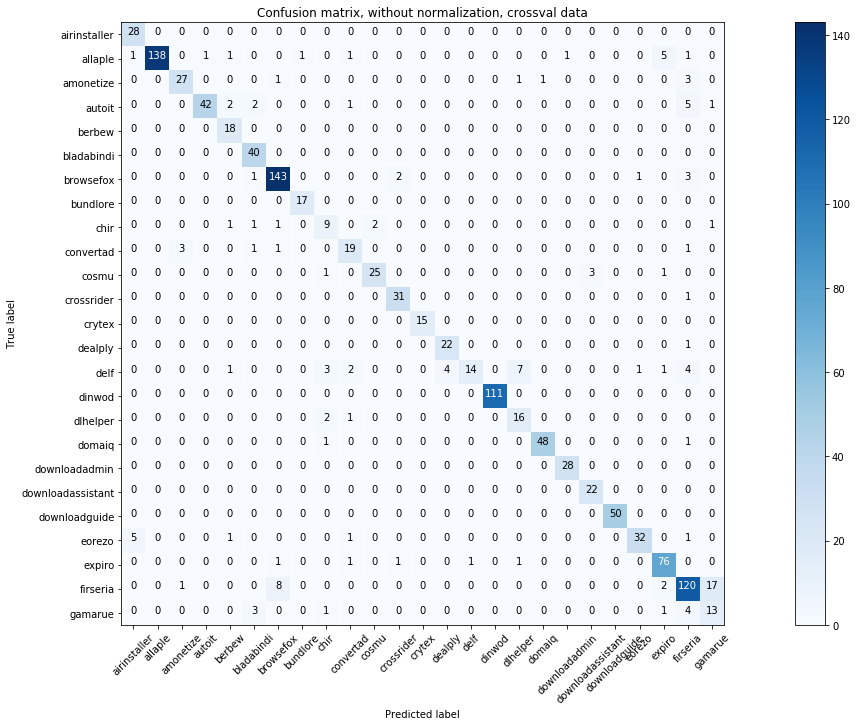

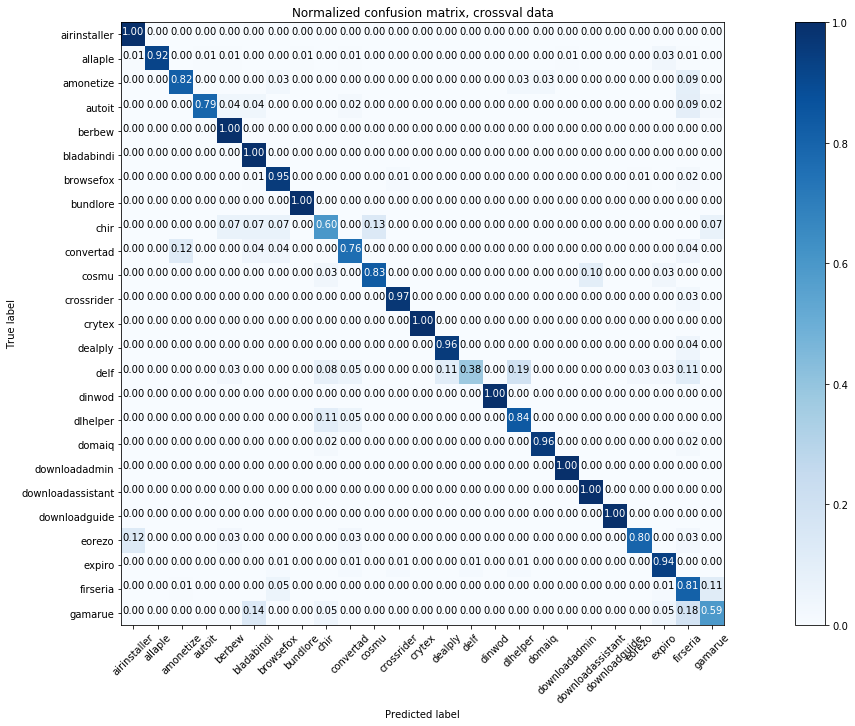

Plotting confusion matrix for test data in base model
Confusion matrix, without normalization
[[ 28   0   0 ...,   0   0   0]
 [  1 130   1 ...,   0   0   0]
 [  0   0  25 ...,   0   0   0]
 ..., 
 [  0   0   1 ...,   0   0   0]
 [  0   0   2 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]]
Normalized confusion matrix
[[ 1.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.01  0.87  0.01 ...,  0.    0.    0.  ]
 [ 0.    0.    0.78 ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.04 ...,  0.    0.    0.  ]
 [ 0.    0.    0.01 ...,  0.    0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.  ]]


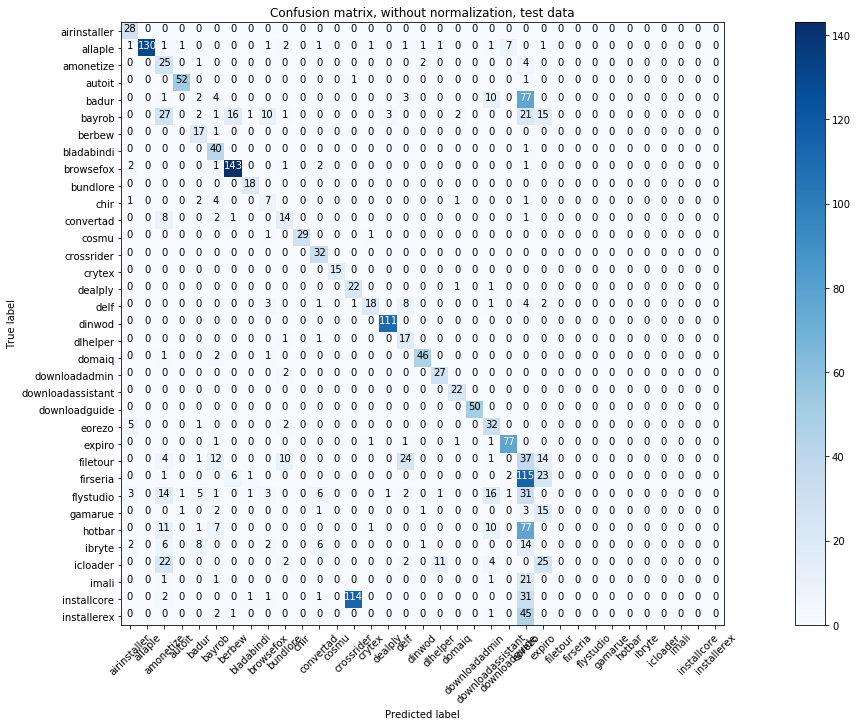

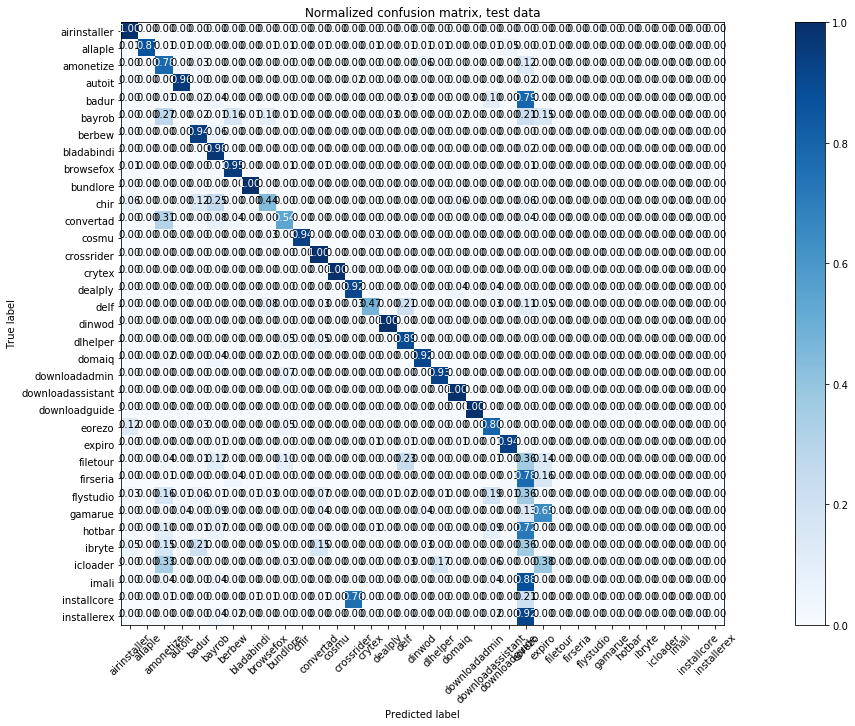

Plotting confusion matrix for test data in drift-aware l2 model
Confusion matrix, without normalization
[[ 27   0   0 ...,   0   0   0]
 [  0 129   1 ...,   1   0   0]
 [  0   0  29 ...,   1   0   0]
 ..., 
 [  0   0   1 ...,   3   0   0]
 [  0   0   0 ...,  27  56   0]
 [  0   0   0 ...,   0   0  47]]
Normalized confusion matrix
[[ 0.96  0.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.86  0.01 ...,  0.01  0.    0.  ]
 [ 0.    0.    0.91 ...,  0.03  0.    0.  ]
 ..., 
 [ 0.    0.    0.04 ...,  0.12  0.    0.  ]
 [ 0.    0.    0.   ...,  0.18  0.37  0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.96]]


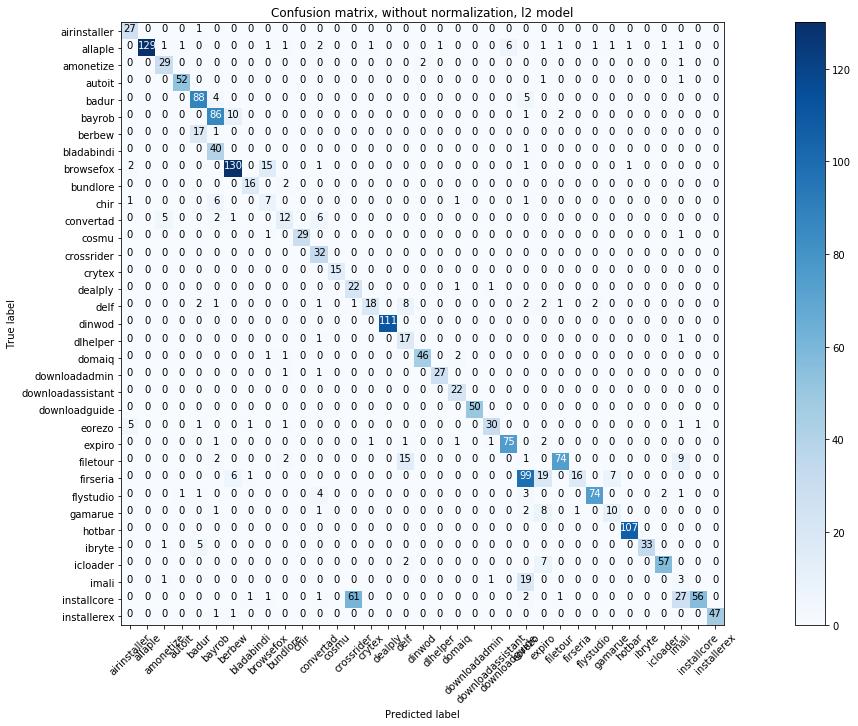

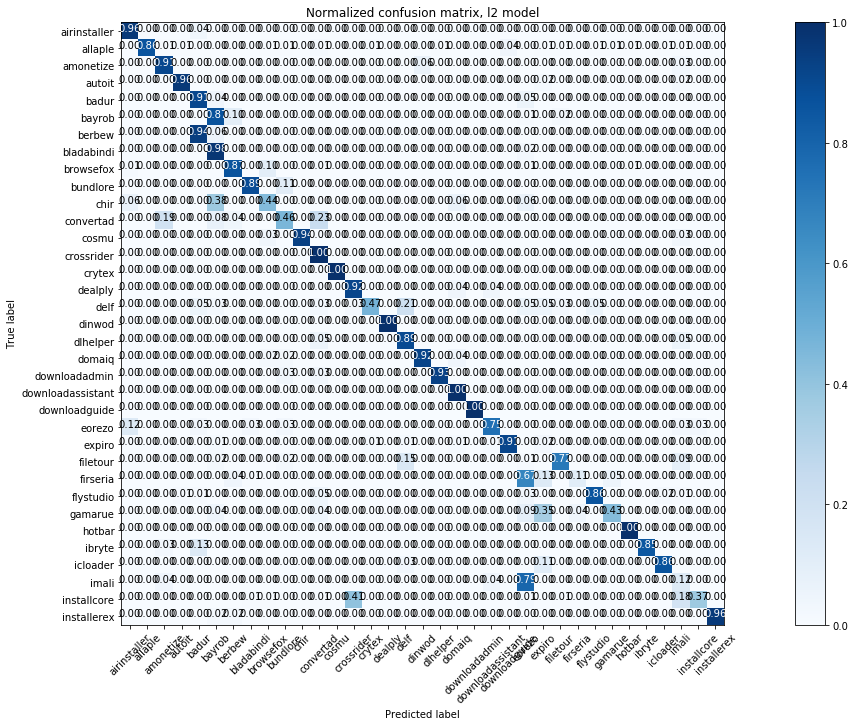

In [33]:
#Confusion Matrices

plt.figure(figsize=(50,30))

print("Computing confusion matrices...")
cnf_matrix_cv = confusion_matrix(mr_cv.target, y_pred_cv)
cnf_matrix_test = confusion_matrix(mr_test.target,y_pred_test)
cnf_matrix_drift_l2 = confusion_matrix(mr_test.target,y_drift_l2)


print("Plotting confusion matrix for crossvalidation data")
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_cv, classes=mr_cv.target_names,
                      title='Confusion matrix, without normalization, crossval data')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_cv, classes=mr_cv.target_names, normalize=True,
                      title='Normalized confusion matrix, crossval data')

plt.show()

print("Plotting confusion matrix for test data in base model")
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_test, classes=mr_test.target_names,
                      title='Confusion matrix, without normalization, test data')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_test, classes=mr_test.target_names, normalize=True,
                      title='Normalized confusion matrix, test data')


plt.show()

print("Plotting confusion matrix for test data in drift-aware l2 model")
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_drift_l2, classes=mr_test.target_names,
                      title='Confusion matrix, without normalization, l2 model')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_drift_l2, classes=mr_test.target_names, normalize=True,
                      title='Normalized confusion matrix, l2 model')

plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(mr_test.target_names,cnf_matrix_drift_l2)

# Normalize the confusion matrix
Csum = np.sum(C,1)
C = C / Csum[None,:]

# Print the confusion matrix
print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

ValueError: Classification metrics can't handle a mix of multiclass and multiclass-multioutput targets